# 3. Model proposals - DF1 (662x16)

LDA, QDA, K-NN, Naive Bayes, Logistic Regression, Decision Trees and Random Forests

### Libraries and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
from sklearn.decomposition import PCA
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, KFold,
    cross_validate
)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, Lasso
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
import scipy.stats as stats
from scipy.stats import boxcox
from pandas.api.types import CategoricalDtype

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from IPython.core.interactiveshell import InteractiveShell
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, GradientBoostingClassifier,
    StackingClassifier, ExtraTreesClassifier
)
from imblearn.under_sampling import RandomUnderSampler
from time import time
from datetime import timedelta

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
DF1 = pd.read_pickle('RiskFactors_processed.pkl.bz2',compression='bz2')
numerical_columns = ['Age', 'Number of sexual partners', 'First sexual intercourse','Num of pregnancies']
categorical_columns = ['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs',
                       'STDs:condylomatosis', 'STDs:syphilis',
                       'STDs:HIV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']
DF1.head()
DF1.shape

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Hormonal Contraceptives,IUD,STDs,STDs:condylomatosis,STDs:syphilis,STDs:HIV,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Cancer
0,0.901,0.758,0.539,0.934,0,1,0,0,0,0,0,0,0,0,0,0
1,0.746,0.851,0.539,0.700,1,1,0,0,0,0,0,0,0,0,0,0
2,0.514,0.314,0.804,0.489,0,1,0,0,0,0,0,0,0,0,0,0
3,0.685,0.506,0.804,0.863,1,1,0,0,0,0,0,0,0,0,0,1
4,0.663,0.314,0.652,0.785,0,1,0,0,0,0,0,0,0,0,0,0


(662, 16)

In this section, we will propose several models, which will then be compared in order to make a final selection. The models that are going to be proposed are: linear classification models and random forests. As this is a classification problem (target takes only 0s or 1s, not continous) linear regression and polynomial regression won't be considered. Even though these models could potentially work, due to the lack of time they won't be studied. We will begin by studying several linear classification models.

The stratify=y argument ensures that the class distribution is maintained in both train and test sets, which is important for imbalanced datasets such as ours.

## 3.1 Linear Classification

#### Support functions

In [3]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [4]:
def compute_metrics(y_real,y_pred):
    # By default it will compute the binary recall of class 1, we can specify which class do we want by using this parameter 
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

### TRAIN TEST VAL RESAMPLING (significantly worse than undersampling, won't be considered)

#### LDA

In [5]:
X = DF1.loc[:,DF1.columns != 'Cancer']
y = DF1['Cancer']

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_train.shape
X_val.shape
X_test.shape
y_train.shape
y_val.shape
y_test.shape

(396, 15)

(133, 15)

(133, 15)

(396,)

(133,)

(133,)

In [6]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)


print('Priors:', lda_model.priors_)
print('Means:\n')
means = pd.DataFrame(lda_model.means_)
means.columns = DF1.columns[:-1]  # Exclude the target variable
means.index = lda_model.classes_
means

print('Coefficients:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = DF1.columns[:-1]  # Exclude the target variable
coefs.index = [0]  # Set a single index value for binary classification
coefs.T

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts.index = [0]  # Set a single index value for binary classification
intercepts

print('Explained Variance Ratio:')
explained_variance_ratio = pd.DataFrame(lda_model.explained_variance_ratio_)
explained_variance_ratio

LinearDiscriminantAnalysis()

Priors: [0.87121212 0.12878788]
Means:



,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Hormonal Contraceptives,IUD,STDs,STDs:condylomatosis,STDs:syphilis,STDs:HIV,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,0.510,0.346,0.642,0.486,0.136,0.646,0.101,0.070,0.046,0.009,0.014,0.009,0.006,0.009,0.014
1,0.498,0.334,0.637,0.489,0.137,0.647,0.137,0.176,0.137,0.000,0.020,0.078,0.020,0.078,0.059


Coefficients:


,0
Age,-0.829
Number of sexual partners,-0.208
First sexual intercourse,-0.359
Num of pregnancies,0.435
Smokes,0.186
Hormonal Contraceptives,-0.087
IUD,0.404
STDs,3.110
STDs:condylomatosis,-1.137
STDs:syphilis,-4.213


Intercepts:


,0
0,-1.904


Explained Variance Ratio:


,0
0,1.0


In [7]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,115,1
1,16,1


In [8]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       116
           1       0.50      0.06      0.11        17

    accuracy                           0.87       133
   macro avg       0.69      0.53      0.52       133
weighted avg       0.83      0.87      0.83       133



In [9]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.059,0.105,0.872,0.518,0.689,0.525


#### QDA

In [10]:
import warnings
warnings.filterwarnings("ignore")

index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model reg                                                             
QDA   0.000e+00              0.353          0.235    0.707    0.527   
      1.000e-04              0.294          0.323    0.842    0.617   
      1.000e-03              0.294          0.333     0.85    0.624   
      1.000e-02              0.235          0.267    0.835    0.587   
      1.000e-01              0.118           0.16    0.842    0.536   
      5.000e-01                0.0            0.0    0.872    0.466   
      1.000e+00                0.0            0.0    0.872    0.466   

                Precision Macro Recall Macro  
model reg                                     
QDA   0.000e+00           0.533        0.556  
      1.000e-04           0.628        0.608  
      1.000e-03           0.642        0.613  
      1.000e-02             0.6        0.579  
      1.000e-01           0.565        0.533  
      5.000e-01           0.436          0.5  
      1.000e+00           0.436          0.5

In [11]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.0001);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

In [12]:
confusion(pd.Series(y_val), pd.Series(y_pred_qda))

predicted,0,1
target,,
0,107,9
1,12,5


In [13]:
results.loc['QDA-0.0001', :] = compute_metrics(y_val, y_pred_qda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.059,0.105,0.872,0.518,0.689,0.525
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608


#### $k$-NN

In [14]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   1               0.235          0.216    0.782    0.545            0.542   
      3               0.118          0.143     0.82    0.521            0.529   
      5               0.059            0.1    0.865    0.513            0.605   
      7               0.059            0.1    0.865    0.513            0.605   
      9               0.059          0.111     0.88    0.523            0.939   
      31                0.0            0.0    0.872    0.466            0.436   
      47                0.0            0.0    0.872    0.466            0.436   
      45                0.0            0.0    0.872    0.466            0.436   
      43                0.0            0.0    0.872    0.466            0.436   
      41                0.0            0.0    0.872    0.466            0.436   
      39                0.0            0.0    0.872    0.466            0.436   
      37                0.0            0.0    0.872    0.466            0.436   
      35                0.0            0.0    0.872    0.466            0.436   
      33                0.0            0.0    0.872    0.466            0.436   
      25                0.0            0.0    0.872    0.466            0.436   
      29                0.0            0.0    0.872    0.466            0.436   
      27                0.0            0.0    0.872    0.466            0.436   
      23                0.0            0.0    0.872    0.466            0.436   
      21                0.0            0.0    0.872    0.466            0.436   
      19                0.0            0.0    0.872    0.466            0.436   
      17                0.0            0.0    0.872    0.466            0.436   
      15                0.0            0.0    0.872    0.466            0.436   
      13                0.0            0.0    0.872    0.466            0.436   
      11                0.0            0.0    0.872    0.466            0.436   
      49                0.0            0.0    0.872    0.466            0.436   

         Recall Macro  
model k                
KNN   1         0.549  
      3          0.52  
      5         0.521  
      7         0.521  
      9         0.529  
      31          0.5  
      47          0.5  
      45          0.5  
      43          0.5  
      41          0.5  
      39          0.5  
      37          0.5  
      35          0.5  
      33          0.5  
      25          0.5  
      29          0.5  
      27          0.5  
      23          0.5  
      21          0.5  
      19          0.5  
      17          0.5  
      15          0.5  
      13          0.5  
      11          0.5  
      49          0.5

In [15]:
knn = KNeighborsClassifier(n_neighbors=1);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results.loc['KNN-1', :] = compute_metrics(y_val, y_pred_knn);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608
KNN-1,0.235,0.216,0.782,0.545,0.542,0.549
LDA,0.059,0.105,0.872,0.518,0.689,0.525


#### Naive Bayes

In [16]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian-NB,0.941,0.222,0.158,0.152,0.48,0.492
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608
KNN-1,0.235,0.216,0.782,0.545,0.542,0.549
LDA,0.059,0.105,0.872,0.518,0.689,0.525


In [17]:
# We need to load again our data so we can pre-process it differently
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_train_numerical = X_train[numerical_columns]
X_train_categorical = X_train[categorical_columns]

X_val_numerical = X_val[numerical_columns]
X_val_categorical = X_val[categorical_columns]

X_test_numerical = X_test[numerical_columns]
X_test_categorical = X_test[categorical_columns]

In [18]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_numerical,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_numerical);

results.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_categorical,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_categorical);

results.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian-NB,0.941,0.222,0.158,0.152,0.48,0.492
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608
KNN-1,0.235,0.216,0.782,0.545,0.542,0.549
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
LDA,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [19]:
combined_prediction_proba= cat_nb.predict_proba(X_val_categorical) * gaussian_nb.predict_proba(X_val_numerical)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian-NB,0.941,0.222,0.158,0.152,0.48,0.492
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608
KNN-1,0.235,0.216,0.782,0.545,0.542,0.549
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
LDA,0.059,0.105,0.872,0.518,0.689,0.525
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [20]:
def only_cero_when_you_are_sure(x):
    if x[0] > 0.6:
        return 0
    else:
        return 1

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_cero_when_you_are_sure, axis=1)

results.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian-NB,0.941,0.222,0.158,0.152,0.48,0.492
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608
KNN-1,0.235,0.216,0.782,0.545,0.542,0.549
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
LDA,0.059,0.105,0.872,0.518,0.689,0.525
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


#### Logistic regression

In [21]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model  C                                                              
LogReg 10.0                  0.059          0.111     0.88    0.523   
       100000.0                0.0            0.0    0.872    0.466   
       10000.0                 0.0            0.0    0.872    0.466   
       1000.0                  0.0            0.0    0.872    0.466   
       100.0                   0.0            0.0    0.872    0.466   
       1.0                     0.0            0.0    0.872    0.466   
       0.1                     0.0            0.0    0.872    0.466   

                Precission Macro Recall Macro  
model  C                                       
LogReg 10.0                0.939        0.529  
       100000.0            0.436          0.5  
       10000.0             0.436          0.5  
       1000.0              0.436          0.5  
       100.0               0.436          0.5  
       1.0                 0.436          0.5  
       0.1                 0.436          0.5

In [22]:
logreg = LogisticRegression(C=100.0).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results.loc['LogReg-100.0', :] = compute_metrics(y_val, y_pred_logreg);
results.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gaussian-NB,0.941,0.222,0.158,0.152,0.48,0.492
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
QDA-0.0001,0.294,0.323,0.842,0.617,0.628,0.608
KNN-1,0.235,0.216,0.782,0.545,0.542,0.549
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
LDA,0.059,0.105,0.872,0.518,0.689,0.525
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5
LogReg-100.0,0.0,0.0,0.872,0.466,0.436,0.5


## UNDER/OVER SAMPLING (protocol considered in the final study)

We've decided to undersample the majority class (0 = patients without cancer) in order to adress class imbalance. Oversampling may affect negatively as random observations of patients with cancer are being generated artificially, which might not be accurate.

In [23]:
# Load the dataset and split into train, test, and validation sets
X = DF1.iloc[:, :-1]  # Features (all columns except the last one)
y = DF1['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Apply resampling techniques to handle class imbalance
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=40) # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)

X_train.shape, y_train.shape

# Evaluate the models
results_aux = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

((123, 15), (123,))

#### LDA

In [24]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)


print('Priors:', lda_model.priors_)
print('Means:\n')
means = pd.DataFrame(lda_model.means_)
means.columns = DF1.columns[:-1]  # Exclude the target variable
means.index = lda_model.classes_
means

print('Coefficients:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = DF1.columns[:-1]  # Exclude the target variable
coefs.index = [0]  # Set a single index value for binary classification
coefs.T

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts.index = [0]  # Set a single index value for binary classification
intercepts

print('Explained Variance Ratio:')
explained_variance_ratio = pd.DataFrame(lda_model.explained_variance_ratio_)
explained_variance_ratio

LinearDiscriminantAnalysis()

Priors: [0.58536585 0.41463415]
Means:



,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Hormonal Contraceptives,IUD,STDs,STDs:condylomatosis,STDs:syphilis,STDs:HIV,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,0.519,0.309,0.640,0.509,0.097,0.681,0.111,0.069,0.056,0.0,0.014,0.000,0.00,0.000,0.000
1,0.498,0.334,0.637,0.489,0.137,0.647,0.137,0.176,0.137,0.0,0.020,0.078,0.02,0.078,0.059


Coefficients:


,0
Age,-1.090e+00
Number of sexual partners,7.367e-01
First sexual intercourse,-1.043e-01
Num of pregnancies,-8.857e-02
Smokes,5.143e-01
Hormonal Contraceptives,-2.446e-02
IUD,1.126e-01
STDs,3.070e+00
STDs:condylomatosis,-1.824e+00
STDs:syphilis,-3.979e-16


Intercepts:


,0
0,-0.289


Explained Variance Ratio:


,0
0,1.0


In [25]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,99,17
1,13,4


In [26]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       116
           1       0.19      0.24      0.21        17

    accuracy                           0.77       133
   macro avg       0.54      0.54      0.54       133
weighted avg       0.80      0.77      0.78       133



In [27]:
results = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.211,0.774,0.539,0.537,0.544


#### QDA

In [28]:
import warnings
warnings.filterwarnings("ignore")

index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model reg                                                             
QDA   1.000e-02              0.353          0.324    0.812    0.608   
      1.000e-03              0.294          0.323    0.842    0.617   
      1.000e-01              0.235          0.276    0.842    0.594   
      1.000e-04              0.176          0.214    0.835    0.561   
      5.000e-01              0.118            0.2     0.88    0.567   
      0.000e+00                0.0            0.0    0.872    0.466   
      1.000e+00                0.0            0.0    0.872    0.466   

                Precision Macro Recall Macro  
model reg                                     
QDA   1.000e-02           0.601        0.616  
      1.000e-03           0.628        0.608  
      1.000e-01           0.613        0.583  
      1.000e-04           0.579        0.554  
      5.000e-01           0.776        0.555  
      0.000e+00           0.436          0.5  
      1.000e+00           0.436          0.5

In [29]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.01);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

In [30]:
results.loc['QDA-0.01', :] = compute_metrics(y_val, y_pred_qda)
results

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.235,0.211,0.774,0.539,0.537,0.544
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616


#### $k$-NN

In [31]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   5               0.706          0.316    0.609    0.521            0.568   
      1               0.647          0.265    0.541    0.466            0.539   
      7               0.647          0.333    0.669    0.557            0.577   
      3               0.647          0.272    0.556    0.476            0.542   
      9               0.588          0.351    0.722    0.587            0.587   
      11              0.529           0.36    0.759    0.606            0.596   
      13              0.412          0.298    0.752    0.574            0.568   
      15              0.353          0.267    0.752    0.559            0.555   
      17              0.294          0.227    0.744    0.537            0.536   
      21              0.176          0.194    0.812    0.544            0.548   
      35              0.176           0.25    0.865    0.588            0.659   
      31              0.118          0.174    0.857    0.548            0.608   
      39              0.118           0.19    0.872    0.561            0.692   
      33              0.118          0.174    0.857    0.548            0.608   
      25              0.118          0.167     0.85    0.542            0.583   
      27              0.118          0.154    0.835    0.531            0.551   
      23              0.118          0.148    0.827    0.526            0.539   
      19              0.118          0.125    0.789    0.503            0.503   
      29              0.059          0.083    0.835    0.496            0.508   
      37              0.059          0.095    0.857    0.509            0.563   
      41              0.059          0.105    0.872    0.518            0.689   
      43              0.059          0.111     0.88    0.523            0.939   
      45                0.0            0.0    0.872    0.466            0.436   
      47                0.0            0.0    0.872    0.466            0.436   
      49                0.0            0.0    0.872    0.466            0.436   

         Recall Macro  
model k                
KNN   5          0.65  
      1         0.586  
      7          0.66  
      3         0.595  
      9         0.665  
      11        0.661  
      13        0.607  
      15        0.582  
      17        0.552  
      21        0.541  
      35        0.571  
      31        0.542  
      39         0.55  
      33        0.542  
      25        0.537  
      27        0.529  
      23        0.524  
      19        0.503  
      29        0.504  
      37        0.516  
      41        0.525  
      43        0.529  
      45          0.5  
      47          0.5  
      49          0.5

In [32]:
knn = KNeighborsClassifier(n_neighbors=5);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results.loc['KNN-5', :] = compute_metrics(y_val, y_pred_knn);
results.sort_values(by='**Recall class 1**',ascending=False)
confusion(pd.Series(y_val), pd.Series(y_pred_knn))

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
LDA,0.235,0.211,0.774,0.539,0.537,0.544


predicted,0,1
target,,
0,69,47
1,5,12


#### Naive Bayes

In [33]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521


In [34]:
# We need to load again our data so we can pre-process it differently
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

X_train_numerical = X_train[numerical_columns]
X_train_categorical = X_train[categorical_columns]

X_val_numerical = X_val[numerical_columns]
X_val_categorical = X_val[categorical_columns]

X_test_numerical = X_test[numerical_columns]
X_test_categorical = X_test[categorical_columns]

In [35]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_numerical,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_numerical);

results.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_categorical,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_categorical);

results.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [36]:
combined_prediction_proba= cat_nb.predict_proba(X_val_categorical) * gaussian_nb.predict_proba(X_val_numerical)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


In [37]:
def only_cero_when_you_are_sure(x):
    if x[0] > 0.6:
        return 0
    else:
        return 1

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_cero_when_you_are_sure, axis=1)

results.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


#### Logistic regression

In [38]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model  C                                                              
LogReg 10.0                  0.059          0.111     0.88    0.523   
       100000.0                0.0            0.0    0.872    0.466   
       10000.0                 0.0            0.0    0.872    0.466   
       1000.0                  0.0            0.0    0.872    0.466   
       100.0                   0.0            0.0    0.872    0.466   
       1.0                     0.0            0.0    0.872    0.466   
       0.1                     0.0            0.0    0.872    0.466   

                Precission Macro Recall Macro  
model  C                                       
LogReg 10.0                0.939        0.529  
       100000.0            0.436          0.5  
       10000.0             0.436          0.5  
       1000.0              0.436          0.5  
       100.0               0.436          0.5  
       1.0                 0.436          0.5  
       0.1                 0.436          0.5

In [39]:
logreg = LogisticRegression(C=10.0).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results.loc['LogReg-10.0', :] = compute_metrics(y_val, y_pred_logreg);
results.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
LogReg-10.0,0.059,0.111,0.88,0.523,0.939,0.529
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


Apparently better predictions, specially k-NN-3 stands out, but it's far from perfect. Now we will apply Lasso to perform feature extraction, we will call the new dataframe DF2.

We will perform linear classifiers again with features extracted on DF2. First without undersampling, and then undersampling.

#### Decision trees

In [40]:
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

In [41]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=X_train.columns,  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=3)  
#graph = graphviz.Source(dot_data)  
#graph 

In [42]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results.sort_values(by='**Recall class 1**', ascending=False)
print(classification_report(y_val, y_pred, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,108,8
1,11,6


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
LogReg-10.0,0.059,0.111,0.88,0.523,0.939,0.529
Gaussian-NB-only-numerical,0.0,0.0,0.872,0.466,0.436,0.5


              precision    recall  f1-score   support

          no       0.91      0.93      0.92       116
         yes       0.43      0.35      0.39        17

    accuracy                           0.86       133
   macro avg       0.67      0.64      0.65       133
weighted avg       0.85      0.86      0.85       133



In [43]:
y_pred_train = model_tree.predict(X_train)

confusion(pd.Series(y_train),pd.Series(y_pred_train))

print(classification_report(y_train, y_pred_train, target_names=['no', 'yes'],))

predicted,0,1
target,,
0,345,0
1,2,49


              precision    recall  f1-score   support

          no       0.99      1.00      1.00       345
         yes       1.00      0.96      0.98        51

    accuracy                           0.99       396
   macro avg       1.00      0.98      0.99       396
weighted avg       0.99      0.99      0.99       396



In [44]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 17
Nodes: 171


In [45]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

recall_class_1_scorer = make_scorer(recall_score, pos_label=1)
f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'recall_class_1': recall_class_1_scorer,
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:40.172523


In [46]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
592,entropy,None,None,4,3,0.579,0.917,0.241,0.851,0.22
792,entropy,10,None,4,3,0.579,0.917,0.241,0.851,0.22
892,entropy,15,None,4,3,0.579,0.917,0.241,0.851,0.22
993,entropy,20,None,4,4,0.577,0.913,0.241,0.844,0.22
992,entropy,20,None,4,3,0.577,0.913,0.241,0.844,0.22


In [47]:
best_params1 = model_5CV.best_params_
best_params1

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3}

In [48]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(pd.Series(y_val), pd.Series(y_pred))
results.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,109,7
1,15,2


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525
LogReg-10.0,0.059,0.111,0.88,0.523,0.939,0.529


#### Random Forests

In [49]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))

print(classification_report(y_train, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

predicted,0,1
target,,
0,345,0
1,2,49


              precision    recall  f1-score   support

          no       0.99      1.00      1.00       345
         yes       1.00      0.96      0.98        51

    accuracy                           0.99       396
   macro avg       1.00      0.98      0.99       396
weighted avg       0.99      0.99      0.99       396

OOB accuracy= 0.8611111111111112


In [50]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(pd.Series(y_val),pd.Series(y_pred))

Validation Accuracy:0.8721804511278195


predicted,0,1
target,,
0,114,2
1,15,2


In [51]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
RF-default,0.118,0.19,0.872,0.561,0.692,0.55
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521
Combined-NB,0.059,0.105,0.872,0.518,0.689,0.525


In [52]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(pd.Series(y_train),pd.Series(pred))
print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,0,1
target,,
0,344,1
1,1,50


              precision    recall  f1-score   support

          no       1.00      1.00      1.00       345
         yes       0.98      0.98      0.98        51

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396

OOB accuracy= 0.8611111111111112


In [53]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,114,2
1,15,2


In [54]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
RF-default,0.118,0.19,0.872,0.561,0.692,0.55
RF-balance,0.118,0.19,0.872,0.561,0.692,0.55
Gaussian-NB,0.059,0.1,0.865,0.513,0.605,0.521


In [55]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:06.998160


In [56]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc', 'mean_test_recall_class_1'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
20,100,6,4,0.553,0.890,0.216,0.808,0.218
28,None,6,4,0.550,0.889,0.211,0.806,0.198
30,None,6,6,0.548,0.889,0.208,0.806,0.198
46,None,6,6,0.540,0.888,0.192,0.803,0.178
38,100,6,6,0.537,0.889,0.185,0.806,0.178


In [57]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': 100,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 200}

In [58]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_leaf=6, min_samples_split=4,
                       n_estimators=200)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
RF-default,0.118,0.19,0.872,0.561,0.692,0.55
RF-balance,0.118,0.19,0.872,0.561,0.692,0.55
RF-best,0.118,0.129,0.797,0.507,0.508,0.507


In [59]:
confusion(pd.Series(y_val),pd.Series(y_pred))

predicted,0,1
target,,
0,104,12
1,15,2


In [60]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier()

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
RF-default,0.118,0.19,0.872,0.561,0.692,0.55
RF-balance,0.118,0.19,0.872,0.561,0.692,0.55
RF-best,0.118,0.129,0.797,0.507,0.508,0.507


In [61]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:03.598883


In [62]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc,mean_test_recall_class_1
30,None,4,6,0.537,0.876,0.198,0.788,0.240
36,100,4,4,0.529,0.871,0.188,0.780,0.240
24,None,2,4,0.527,0.883,0.172,0.795,0.178
46,None,4,6,0.526,0.870,0.182,0.778,0.240
22,100,4,6,0.523,0.876,0.171,0.785,0.200


In [63]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 150}

In [64]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='**Recall class 1**',ascending=False)

ExtraTreesClassifier(class_weight='balanced', min_samples_leaf=4,
                     min_samples_split=6, n_estimators=150)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
extra_trees-best,0.471,0.39,0.812,0.64,0.625,0.666
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
RF-default,0.118,0.19,0.872,0.561,0.692,0.55
RF-balance,0.118,0.19,0.872,0.561,0.692,0.55


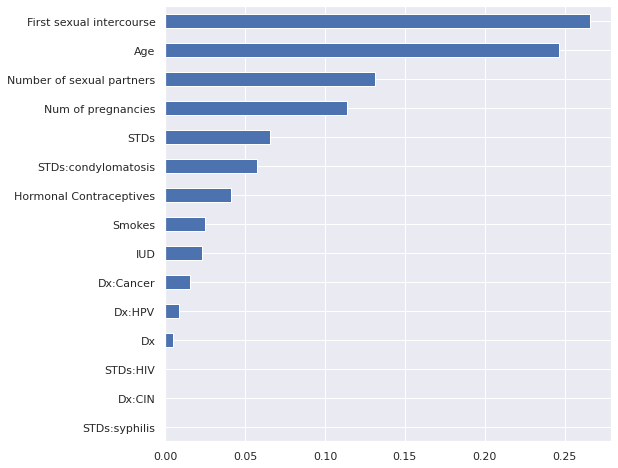

In [65]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

## Results

In [66]:
results.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5,0.706,0.316,0.609,0.521,0.568,0.65
extra_trees-best,0.471,0.39,0.812,0.64,0.625,0.666
QDA-0.01,0.353,0.324,0.812,0.608,0.601,0.616
Combined-NB-tuned,0.353,0.364,0.842,0.637,0.64,0.633
DT-default,0.353,0.387,0.857,0.653,0.668,0.642
LDA,0.235,0.211,0.774,0.539,0.537,0.544
Gaussian-NB-only-categorical,0.176,0.24,0.857,0.581,0.631,0.567
DT-best,0.118,0.154,0.835,0.531,0.551,0.529
RF-default,0.118,0.19,0.872,0.561,0.692,0.55
RF-balance,0.118,0.19,0.872,0.561,0.692,0.55


### Testing the best model

In [67]:
X = DF1.iloc[:, :-1]  # Features (all columns except the last one)
y = DF1['Cancer']  # Target variable (last column)

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=40) # Adjust the sampling strategy as needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)

results_test = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [68]:
knn = KNeighborsClassifier(n_neighbors=5);
knn = knn.fit(X_train,y_train);

# Predict the target variable for the validation set
y_pred_knn_val = knn.predict(X_val)
results_test.loc['KNN-5-val', :] = compute_metrics(y_val, y_pred_knn_val);
confusion(pd.Series(y_val), pd.Series(y_pred_knn_val))

# Predict the target variable for the test set
y_pred_knn_test = knn.predict(X_test)
results_test.loc['KNN-5-test', :] = compute_metrics(y_test, y_pred_knn_test);
confusion(pd.Series(y_test), pd.Series(y_pred_knn_test))

results_test.sort_values(by='**Recall class 1**',ascending=False)

predicted,0,1
target,,
0,69,47
1,5,12


predicted,0,1
target,,
0,80,36
1,7,10


,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN-5-val,0.706,0.316,0.609,0.521,0.568,0.65
KNN-5-test,0.588,0.317,0.677,0.553,0.568,0.639
